In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
from tensorflow.keras import backend as keras_backend
import numpy as np

gpu_on = True

if gpu_on :
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from src.data_loader.star_gan import StarGanDataloader
from tensorflow.keras.applications.inception_v3 import preprocess_input
from glob import glob

task = "star_gan"
data_set_name = "SN_colon"
batch_size = 4
on_memory = False
argumentation_proba = 0.8
argumentation_policy_dict = {
    "positional": True,
    "noise": False,
    "brightness_contrast": False,
    "color": False,
    "to_jpeg": False
}
target_size = (256, 256)
interpolation = "bilinear"
class_mode = "categorical"
dtype = "float32"

train_image_path_list = glob(f"./datasets/{task}/{data_set_name}/train/*/*/*.png")
test_image_path_list = glob(f"./datasets/{task}/{data_set_name}/test/*/*/*.png")

label_list = os.listdir(f"./datasets/{task}/{data_set_name}/train")
label_level = 2
label_to_index_dict = {label: index for index, label in enumerate(label_list)}
index_to_label_dict = {index: label for index, label in enumerate(label_list)}


train_data_loader = StarGanDataloader(image_path_list=train_image_path_list,
                                      label_to_index_dict=label_to_index_dict,
                                      label_level=label_level,
                                      batch_size=batch_size,
                                      on_memory=on_memory,
                                      argumentation_proba=argumentation_proba,
                                      argumentation_policy_dict=argumentation_policy_dict,
                                      preprocess_input=preprocess_input,
                                      target_size=target_size,
                                      interpolation=interpolation,
                                      shuffle=True,
                                      class_mode=class_mode,
                                      dtype=dtype
                                      )
test_data_loader = StarGanDataloader(image_path_list=test_image_path_list,
                                     label_to_index_dict=label_to_index_dict,
                                     label_level=label_level,
                                     batch_size=1,
                                     on_memory=False,
                                     argumentation_proba=0,
                                     argumentation_policy_dict=argumentation_policy_dict,
                                     preprocess_input=preprocess_input,
                                     target_size=target_size,
                                     interpolation=interpolation,
                                     shuffle=False,
                                     class_mode=class_mode,
                                     dtype=dtype
                                     )


Total data num 500000 with 5 classes
Total data num 5001 with 5 classes


In [3]:
from copy import deepcopy

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.activations import sigmoid
from tensorflow.image import ssim
import segmentation_models as sm
from tensorflow.keras.applications import InceptionV3

from src.model.star_gan_v3 import StarGan
from src.util.custom_loss import dice_score
from src.util.loss_cycle_gan import get_channel_weighted_dice_loss, get_channel_weighted_mse_loss
from src.model.inceptionv3_tf_2_5 import InceptionV3
from src.model.inceptionv3_unet import Unet

BACKBONE="inceptionv3"
DROPOUT_RATIO = 0.5
generator_optimizer = Nadam(1e-4, beta_1=0.5)
discriminator_optimizer = Nadam(1e-4, beta_1=0.5)
input_image_shape = (*target_size, 3)
output_image_shape = (*target_size, 3)

# encoder_features="default" => use 4 skip connection
# encoder_features="[] => not use skip connection
# base_U_net = sm.Unet(backbone_name=BACKBONE, 
#                       input_shape=(None, None, 3),
#                       encoder_features=[],
#                       classes=3, activation="tanh")

generator = sm.Unet(backbone_name=BACKBONE, 
                  input_shape=(None, None, 13),
                  encoder_weights=None,
                  classes=3, activation="tanh")

base_discriminator = InceptionV3(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(None,None,3),
    classes=None,
    normliazation="LayerNormalization",
    pooling=None,
    classifier_activation=None
)

# (Batch_Size,?)
discriminator_output = GlobalAveragePooling2D()(base_discriminator.output)
discriminator_output = Dropout(DROPOUT_RATIO)(discriminator_output)
# let's add a fully-connected layer
# (Batch_Size,1)
discriminator_output = Dense(1024, activation='relu')(discriminator_output)
# (Batch_Size,1024)
discriminator_output = Dropout(DROPOUT_RATIO)(discriminator_output)
predictions = Dense(len(label_list), activation='softmax')(discriminator_output)

discriminator = Model(base_discriminator.input, [base_discriminator.output, predictions])


star_gan_model = StarGan(
    generator=generator, 
    discriminator=discriminator,
    lambda_reconstruct=10.0,
    lambda_identity=0.1,
)

star_gan_model.compile(
    batch_size = batch_size,
    image_shape = target_size,
    label_num = len(label_list),
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
#     image_loss_fn=get_channel_weighted_mse_loss
)


Segmentation Models: using `keras` framework.


C:\Users\gr300\anaconda3\lib\site-packages\keras_applications\imagenet_utils.py:276: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 13 input channels.
  warnings.warn(


In [4]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt

class GANMonitor(Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, data_loader, save_image_path, num_img=4):
        self.data_loader = data_loader
        self.num_img = num_img
        self.save_image_path = save_image_path
        
        os.makedirs(save_image_path, exist_ok=True)
        
    def on_epoch_end(self, epoch, logs=None):
        
        len_data_loader = len(self.data_loader)
        random_index = range(len_data_loader)
        random_index = np.random.permutation(random_index)[:self.num_img]
        
        _, ax = plt.subplots(self.num_img, 4, figsize=(12, 12))
        for current_index, image_index in enumerate(random_index):
            total_image_array, total_label_array = self.data_loader[image_index]
            image_array, target_image_array = total_image_array 
            label_array, target_label_array = total_label_array 
            iamge_array_name = self.data_loader.data_getter.target_image_path_dict[image_index]
            
            label_repeated_x = layers.Reshape(
                (1, 1, len(label_list)))(label_array)
            label_repeated_x = keras_backend.repeat_elements(
                label_repeated_x, target_size[0], axis=1)
            label_repeated_x = keras_backend.repeat_elements(
                label_repeated_x, target_size[1], axis=2)

            label_repeated_y = layers.Reshape(
                (1, 1, len(label_list)))(target_label_array)
            label_repeated_y = keras_backend.repeat_elements(
                label_repeated_y, target_size[0], axis=1)
            label_repeated_y = keras_backend.repeat_elements(
                label_repeated_y, target_size[1], axis=2)
            
            prediction = self.model.generator_G(image_array).numpy()[0]
            reverse_prediction = self.model.generator_F(target_image_array).numpy()[0]
            
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            reverse_prediction = (reverse_prediction * 127.5 + 127.5).astype(np.uint8)
            
            image_array = (image_array[0] * 127.5 + 127.5).astype(np.uint8)
            target_image_array = (target_image_array[0] * 127.5 + 127.5).astype(np.uint8)
            
            ax[current_index, 0].imshow(image_array)
            ax[current_index, 1].imshow(prediction)
            ax[current_index, 0].set_title("Input image_x")
            ax[current_index, 1].set_title("Translated image_y")
#             ax[current_index, 0].axis("off")
#             ax[current_index, 1].axis("off")

            ax[current_index, 2].imshow(target_image_array)
            ax[current_index, 3].imshow(reverse_prediction)
            ax[current_index, 2].set_title("Input image_y")
            ax[current_index, 3].set_title("Translated image_x")
#             ax[current_index, 0].axis("off")
#             ax[current_index, 1].axis("off")

            prediction = image.array_to_img(prediction)
            reverse_prediction = image.array_to_img(reverse_prediction)
        plt.savefig(f"{self.save_image_path}/generated_image_{epoch+1}")
        plt.show()
        plt.close()
        
class ModelCheckpointWithWeight(ModelCheckpoint):
    """A callback to generate and save images after each epoch"""

    def __init__(self, *args, **kwargs):
        super(ModelCheckpointWithWeight, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        super(ModelCheckpointWithWeight, self).on_epoch_end(epoch, logs=logs)
        save_folder = self.filepath.format(epoch=epoch+1)
        
        self.model.generator_G.save_weights(f"{save_folder}/generator_G.hdf5")
        self.model.generator_F.save_weights(f"{save_folder}/generator_F.hdf5")
        self.model.discriminator_X.save_weights(f"{save_folder}/discriminator_X.hdf5")
        self.model.discriminator_Y.save_weights(f"{save_folder}/discriminator_Y.hdf5")

class TurnOffIdentitiyLoss(Callback):
    def __init__(self, target_epoch=5):
        self.target_epoch = target_epoch
    def on_epoch_end(self, epoch, logs=None):
        epoch = epoch + 1
        print(f"is current identity loss turn on: {self.model.turn_on_identity_loss}")
        if epoch >= self.target_epoch:
            self.model.turn_on_identity_loss = False

def decay_learning_rate_scheduler(
    epoch, learning_rate, decay_epoch=10, decay_rate=0.5
):
    if epoch > 0 and epoch < decay_epoch:
        learning_rate = learning_rate * decay_rate
    
    return learning_rate

decay_up_lr_scheduler = LearningRateScheduler(decay_learning_rate_scheduler, verbose=1)


In [5]:
from datetime import date

# YY/MM/dd
today = date.today()
today_str = today.strftime("%Y-%m-%d")

checkpoint_folder = f"./result_daily/{task}/{data_set_name}/{today_str}/"
checkpoint_filepath = checkpoint_folder + "/check_points/cyclegan_checkpoints.{epoch:03d}/"
save_image_path = f"{checkpoint_folder}/images/"
os.makedirs(checkpoint_folder, exist_ok=True)

plotter = GANMonitor(data_loader=test_data_loader, save_image_path=save_image_path, num_img=4)
model_checkpoint_callback = ModelCheckpointWithWeight(
    filepath=checkpoint_filepath
)

turn_off_identity_loss_callback = TurnOffIdentitiyLoss()

In [6]:
star_gan_model.fit(
    train_data_loader,
    epochs=100,
    callbacks=[model_checkpoint_callback],
)

Epoch 1/100
   809/125000 [..............................] - ETA: 108:27:12 - total_generator_loss_x: 5.5812 - total_generator_loss_y: 5.7565 - D_loss_x: 266.3930 - D_loss_y: 1726.0566 - generator_loss_x: -0.3705 - generator_loss_y: -0.3705 - identity_loss_x: 0.1417 - identity_loss_y: 0.3073 - reconstruct_loss_x: 1.5553 - reconstruct_loss_y: 1.5719

KeyboardInterrupt: 

# inference

In [9]:
star_gan_model.generator.load_weights("generator.hdf5")
star_gan_model.discriminator.load_weights("discriminator.hdf5")

In [7]:
total_image_array, total_label_array = train_data_loader[15]

image_array, target_image_array = total_image_array 
label_array, target_label_array = total_label_array 

print(np.array_equal(image_array, target_image_array))
print(label_array)
print(target_label_array)
print(label_array == target_label_array)


False
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
[[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True False  True  True False]
 [False  True False  True  True]]


In [8]:
from src.data_loader.utils import imread  
from tensorflow.keras import backend as keras_backend
from tensorflow.keras import layers
import cv2

index = 1193

image_array, label_array = train_data_loader[index]

image_array, target_image_array = image_array[0], image_array[1]
label_array, target_label_array = label_array[0], label_array[1]

print(np.array_equal(image_array, target_image_array))
print(label_array)
print(target_label_array)
print(label_array == target_label_array)

label_repeated_x = layers.Reshape(
    (1, 1, len(label_list)))(label_array)
label_repeated_x = keras_backend.repeat_elements(
    label_repeated_x, target_size[0], axis=1)
label_repeated_x = keras_backend.repeat_elements(
    label_repeated_x, target_size[1], axis=2)

label_repeated_y = layers.Reshape(
    (1, 1, len(label_list)))(target_label_array)
label_repeated_y = keras_backend.repeat_elements(
    label_repeated_y, target_size[0], axis=1)
label_repeated_y = keras_backend.repeat_elements(
    label_repeated_y, target_size[1], axis=2)

# target_predicted_image_array = (image_array / 127.5) - 1
target_predicted_image_array = keras_backend.constant(image_array)
real_x_for_y = keras_backend.concatenate(
    [target_predicted_image_array, label_repeated_x, label_repeated_y], axis=-1)
target_predicted_image_array = star_gan_model.generator.predict(real_x_for_y)
target_predicted_image_array = (target_predicted_image_array + 1) * 127.5
target_predicted_image_array = target_predicted_image_array.astype("uint8")

# predicted_image_array = (target_image_array / 127.5) - 1 
predicted_image_array = keras_backend.constant(target_image_array)
real_y_for_x = keras_backend.concatenate(
    [predicted_image_array, label_repeated_y, label_repeated_x], axis=-1)
predicted_image_array = star_gan_model.generator.predict(real_y_for_x)
predicted_image_array = (predicted_image_array + 1) * 127.5
predicted_image_array = predicted_image_array.astype("uint8")

False
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]
[[ True False  True  True False]
 [ True False  True False  True]
 [ True  True False False  True]
 [False  True  True  True False]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


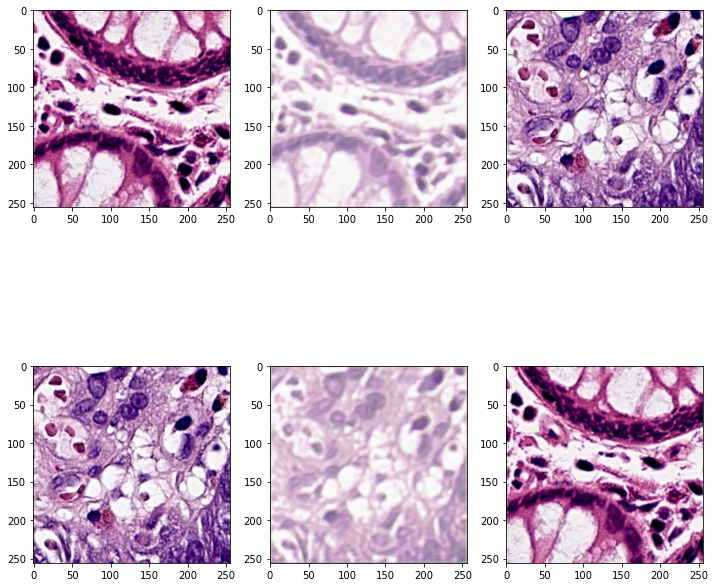

In [9]:
_, ax = plt.subplots(2, 3, figsize=(12, 12))
ax[0, 0].imshow(image_array[0])
ax[0, 1].imshow(target_predicted_image_array[0])
ax[0, 2].imshow(target_image_array[0])
ax[1, 0].imshow(target_image_array[0])
ax[1, 1].imshow(predicted_image_array[0])
ax[1, 2].imshow(image_array[0])

In [ ]:
from src.data_loader.utils import imread  
from tensorflow.keras import backend as keras_backend
from tensorflow.keras import layers
import cv2

index = 1191

image_array, label_array = test_data_loader[0]

image_array, target_image_array = image_array[0], image_array[1] 
label_array, target_label_array = label_array[0], label_array[1]

image_array = imread(f'./datasets/star_gan/SN_colon/test/03/03S-10-1-150603/03S-10-1-150603_1191.png', channel="rgb")
target_image_array = imread(f'./datasets/star_gan/SN_colon/test/19/19S-72737-A1/19S-72737-A1_1078.png', channel="rgb")

label_repeated_x = layers.Reshape(
    (1, 1, len(label_list)))(label_array)
label_repeated_x = keras_backend.repeat_elements(
    label_repeated_x, target_size[0], axis=1)
label_repeated_x = keras_backend.repeat_elements(
    label_repeated_x, target_size[1], axis=2)

label_repeated_y = layers.Reshape(
    (1, 1, len(label_list)))(target_label_array)
label_repeated_y = keras_backend.repeat_elements(
    label_repeated_y, target_size[0], axis=1)
label_repeated_y = keras_backend.repeat_elements(
    label_repeated_y, target_size[1], axis=2)

target_predicted_image_array = (image_array / 127.5) - 1
target_predicted_image_array = np.expand_dims(target_predicted_image_array, axis=0)
target_predicted_image_array = keras_backend.constant(target_predicted_image_array)
real_x_for_y = keras_backend.concatenate(
    [target_predicted_image_array, label_repeated_x, label_repeated_y], axis=-1)
target_predicted_image_array = star_gan_model.generator.predict(real_x_for_y)[0]
target_predicted_image_array = (target_predicted_image_array + 1) * 127.5
target_predicted_image_array = target_predicted_image_array.astype("uint8")

predicted_image_array = (target_image_array / 127.5) - 1 
predicted_image_array = np.expand_dims(predicted_image_array, axis=0)
predicted_image_array = keras_backend.constant(predicted_image_array)
real_y_for_x = keras_backend.concatenate(
    [predicted_image_array, label_repeated_y, label_repeated_x], axis=-1)
predicted_image_array = star_gan_model.generator.predict(real_y_for_x)[0]
predicted_image_array = (predicted_image_array + 1) * 127.5
predicted_image_array = predicted_image_array.astype("uint8")


In [ ]:
_, ax = plt.subplots(2, 3, figsize=(12, 12))
ax[0, 0].imshow(image_array)
ax[0, 1].imshow(target_predicted_image_array)
ax[0, 2].imshow(target_image_array)
ax[1, 0].imshow(target_image_array)
ax[1, 1].imshow(predicted_image_array)
ax[1, 2].imshow(image_array)

# Unused Code

In [23]:
image_array, target_image_array = train_data_loader[0]

In [24]:
source_array = image_array[0]
source_array = (source_array + 1) * 127.5
source_array = source_array.astype("uint8")

In [25]:
converted = generator_G(image_array)[0]
converted = np.array(converted)
converted = (converted + 1) * 127.5
converted = converted.astype("uint8")

In [26]:
temp_array = image_array[0]
temp_array = (temp_array + 1) * 127.5
temp_array = temp_array.astype("uint8")

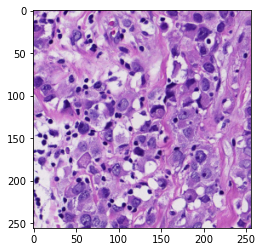

In [28]:
from matplotlib import pyplot as plt

plt.imshow(source_array)

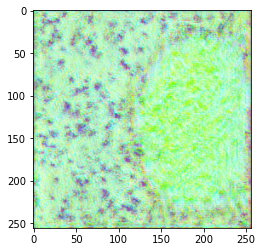

In [29]:
from matplotlib import pyplot as plt

plt.imshow(converted)

# Unused Code

In [ ]:
y_true = train_data_loader[0][0]
y_true = tf.convert_to_tensor(y_true)
one_array = np.ones((1,512,512,3))
one_diff_array = deepcopy(one_array)
one_diff_array[:,:,:,0] = 0
one_diff_array[:,:30,:30,1] = 0

one_array = tf.convert_to_tensor(one_array)
one_diff_array = tf.convert_to_tensor(one_diff_array)

In [ ]:
beta = 0.7
CHANNEL_WEIGHTED_AXIS = [1, 2]
y_true = one_array
y_pred = one_diff_array
smooth = K.epsilon()

alpha = 1 - beta
prevalence_per_channel = \
    K.mean((y_true + 1) / 2, axis=CHANNEL_WEIGHTED_AXIS)

tp = K.sum(y_true * y_pred, axis=CHANNEL_WEIGHTED_AXIS)
tn = K.sum((1 - y_true) * (1 - y_pred), axis=CHANNEL_WEIGHTED_AXIS)
fp = K.sum(y_pred, axis=CHANNEL_WEIGHTED_AXIS) - tp
fn = K.sum(y_true, axis=CHANNEL_WEIGHTED_AXIS) - tp

channel_weighted_dice_loss = \
    (tp + smooth) / (tp + alpha * fn + beta * fp + smooth) * \
    (smooth + prevalence_per_channel)

print(f"channel_weighted_dice: {channel_weighted_dice_loss}")
print(f"channel_weighted_dice_loss: {channel_weighted_dice_loss.shape}")

channel_weighted_dice_loss = K.mean(channel_weighted_dice_loss)

print(f"prevalence_per_channel_shape: {prevalence_per_channel.shape}")
print(f"true_positive_shape: {tp.shape}")
print(f"false_positive_shape: {tp.shape}")
print(f"false_negative_shape: {tn.shape}")
print(f"channel_weighted_dice: {channel_weighted_dice_loss}")


In [ ]:
from tensorflow.keras import backend as K

beta=0.7
CHANNEL_WEIGHTED_AXIS=[1,2]
smooth=K.epsilon()

alpha = 1 - beta

y_true = tf.constant(image_array)
y_pred = tf.constant(image_array)

y_true = (y_true + 1 + smooth) / 2
y_pred = (y_pred + 1 + smooth) / 2

prevalence_per_channel = K.mean(y_true, axis=CHANNEL_WEIGHTED_AXIS)

weight_per_channel = 1 / prevalence_per_channel
weight_per_channel_sum = K.sum(weight_per_channel, axis=-1)
weight_per_channel_sum = tf.expand_dims(weight_per_channel_sum, axis=-1)
weight_per_channel = weight_per_channel / weight_per_channel_sum

tp = K.sum(y_true * y_pred, axis=CHANNEL_WEIGHTED_AXIS)
fp = K.sum(y_pred, axis=CHANNEL_WEIGHTED_AXIS) - tp
fn = K.sum(y_true, axis=CHANNEL_WEIGHTED_AXIS) - tp

channel_weighted_dice_loss = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth) * \
    (smooth + weight_per_channel)

print(channel_weighted_dice_loss)

channel_weighted_dice_loss = K.mean(channel_weighted_dice_loss)